In [5]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.special import expit

import import_ipynb
from part1_data_fitting import Model

In [14]:
FIG_FOLDER = 'fig'
SOURCE_FOLDER = os.path.join('data', 'source')
BACKUP_FOLDER = os.path.join('data', 'backup')
print(f"The source folder is: {os.path.abspath(SOURCE_FOLDER)}")
print(f"The figure folder is: {os.path.abspath(FIG_FOLDER)}")
print(f"The backup folder is: {os.path.abspath(BACKUP_FOLDER)}")

# Create folders
for f in SOURCE_FOLDER, FIG_FOLDER, BACKUP_FOLDER:
    os.makedirs(f, exist_ok=True)

The source folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/source
The figure folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/fig
The backup folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/backup


### Load the results

In [15]:
df_fit = pd.read_csv(os.path.join(BACKUP_FOLDER, "df_fit_w10.csv"))
df_fit.date = pd.to_datetime(df_fit.date)
df_fit

,Unnamed: 0,distortion,precision,risk_aversion,date,monkey,condition,n
0,0,0.200000,4.270073,0.990000,2020-06-25,Ola,gain,184
1,1,0.200000,2.770975,0.371047,2020-06-26,Ola,gain,190
2,2,0.200000,3.808986,0.430657,2020-06-27,Ola,gain,208
3,3,0.200000,3.722515,0.085129,2020-06-28,Ola,gain,220
4,4,0.200000,4.670508,0.132597,2020-06-29,Ola,gain,244
...,...,...,...,...,...,...,...,...
2607,57,0.200000,10.000000,-0.990000,2020-10-20,Yin,loss,77
2608,58,0.313026,10.000000,-0.990000,2020-10-21,Yin,loss,71
2609,59,0.200000,10.000000,-0.990000,2020-10-22,Yin,loss,70
2610,60,1.159000,10.000000,0.790311,2020-10-24,Yin,loss,66


In [16]:
df_elo = pd.read_csv(os.path.join(BACKUP_FOLDER, "df_elo.csv"), index_col=0)
df_elo.index = pd.to_datetime(df_elo.index)
df_elo

,nem,yak,ner,yoh,nen,wot,pac,las,anu,ola,...,olg,jea,pat,bar,ces,lad,ber,dor,eri,fic
date,,,,,,,,,,,,,,,,,,,,,
2016-10-25,1024,1009,1018,984,991,1010,991,982,991,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-26,1032,1009,1018,1003,991,1010,982,964,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-27,1032,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-28,1041,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-29,1063,1009,1018,1011,991,1010,975,941,984,1008,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-21,938,1243,961,840,1018,1234,1379,713,1117,1287,...,933,760,841,1083,837,753,743,766,702,579
2020-10-22,970,1243,962,840,1018,1234,1347,716,1105,1296,...,935,755,841,1070,832,753,743,795,702,566
2020-10-23,971,1243,970,840,1018,1234,1347,735,1105,1296,...,920,751,841,1072,838,753,758,773,668,566


# Correlation

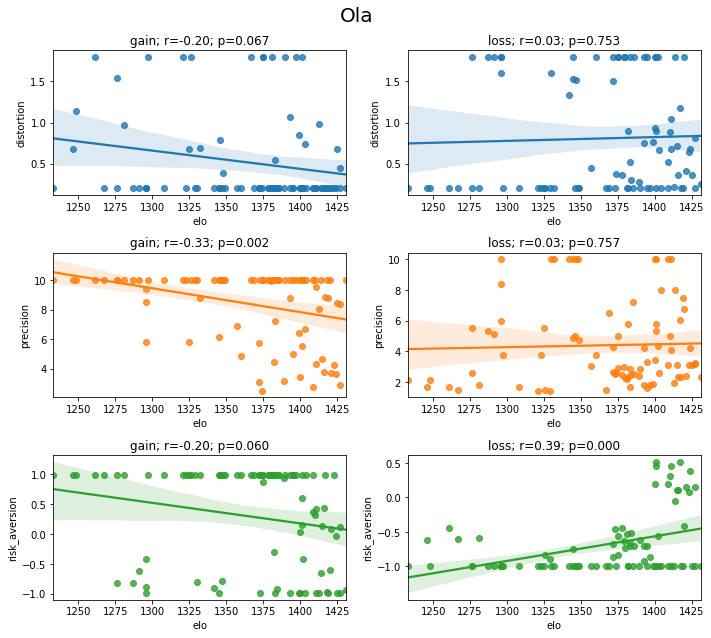

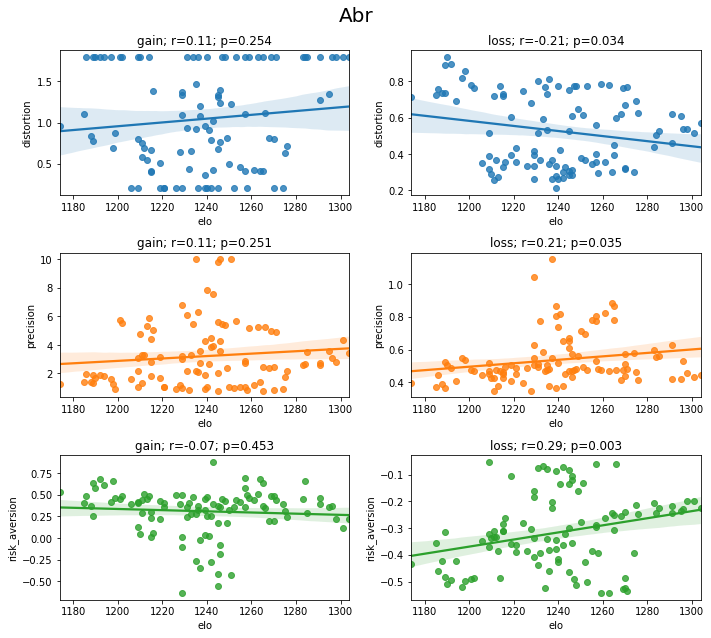

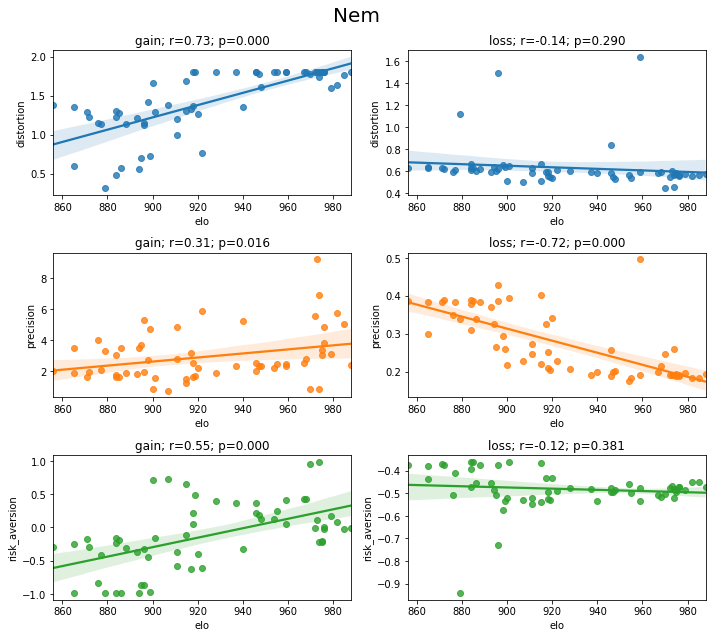

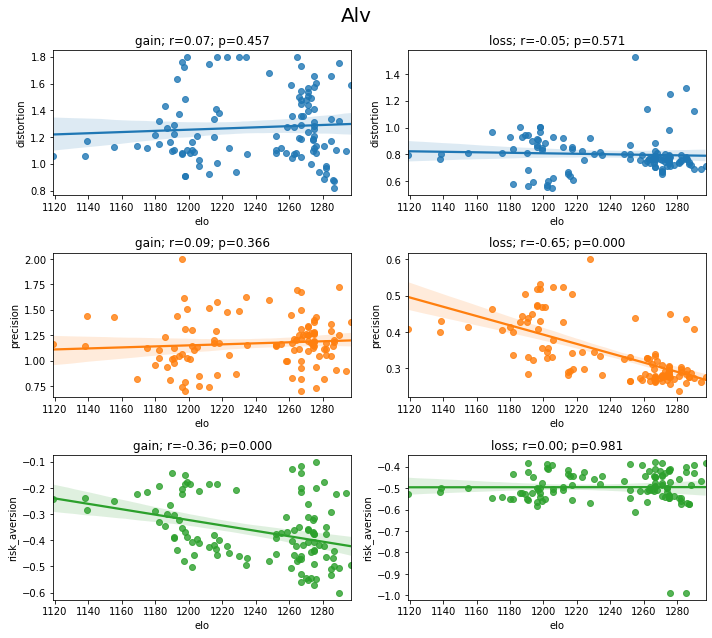

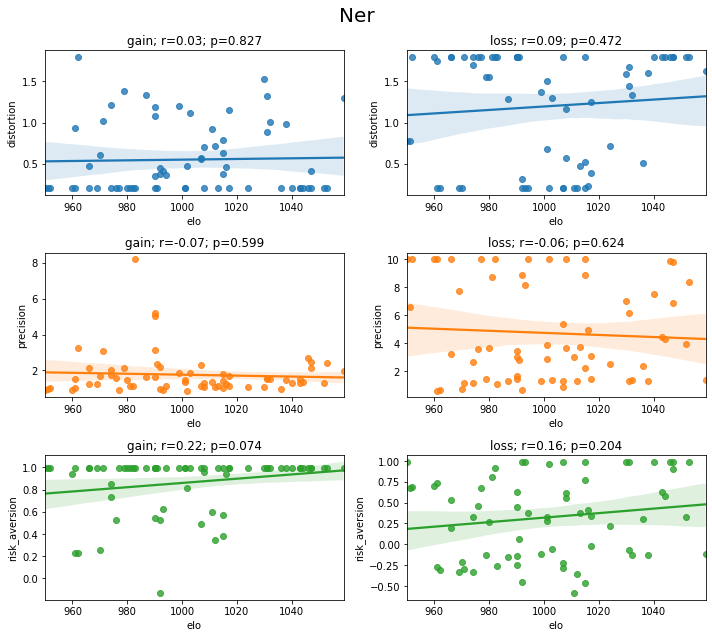

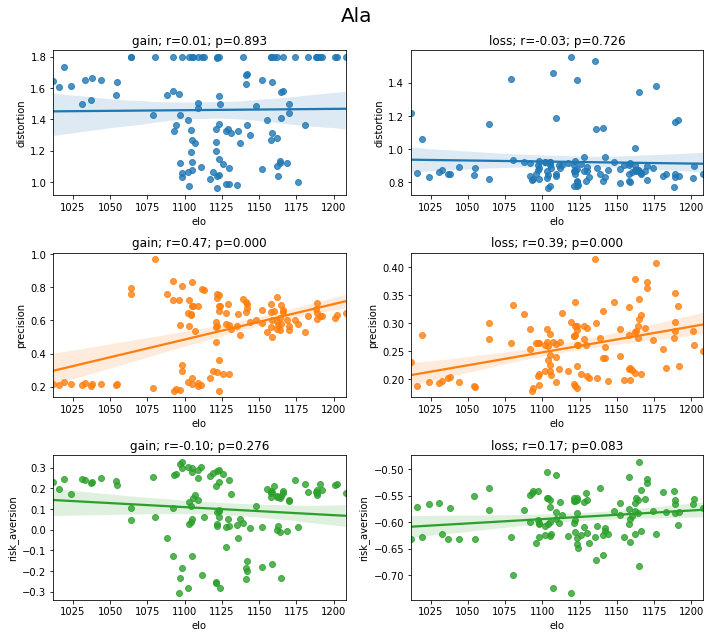

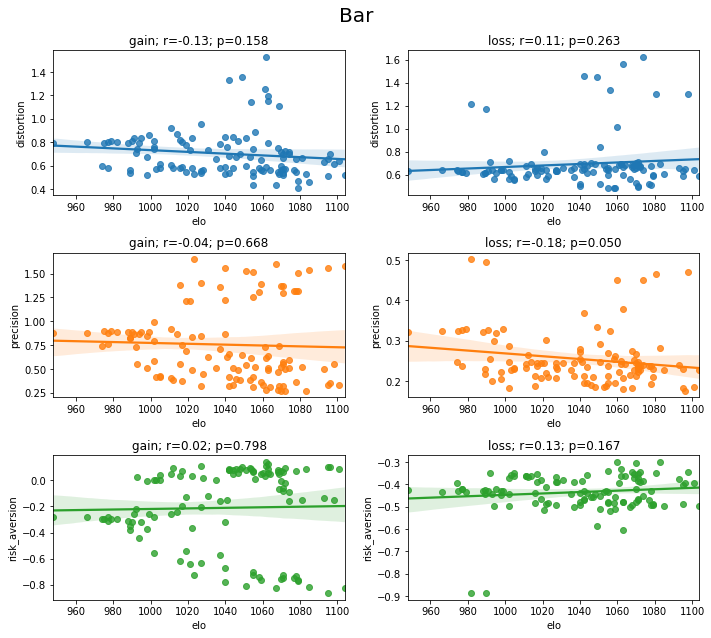

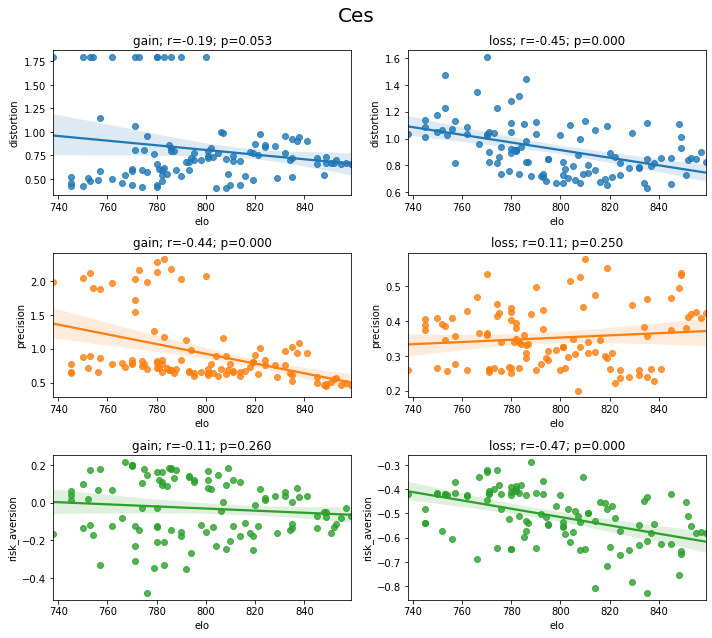

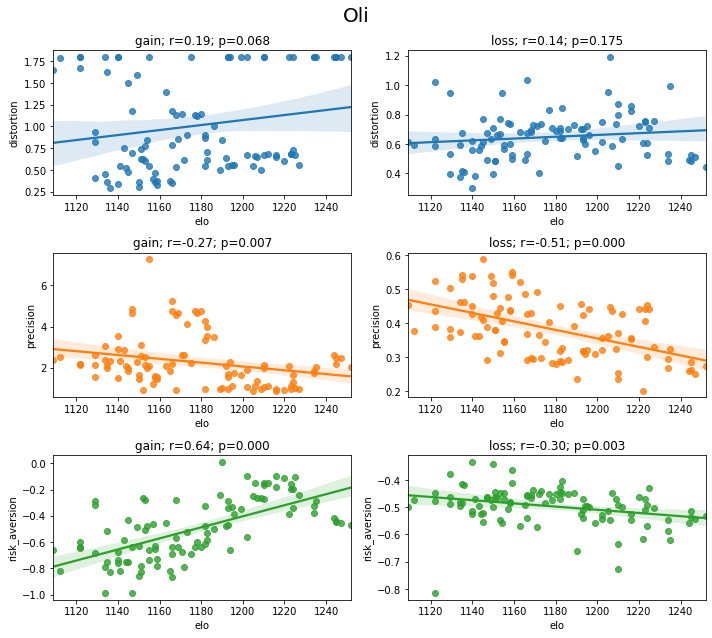

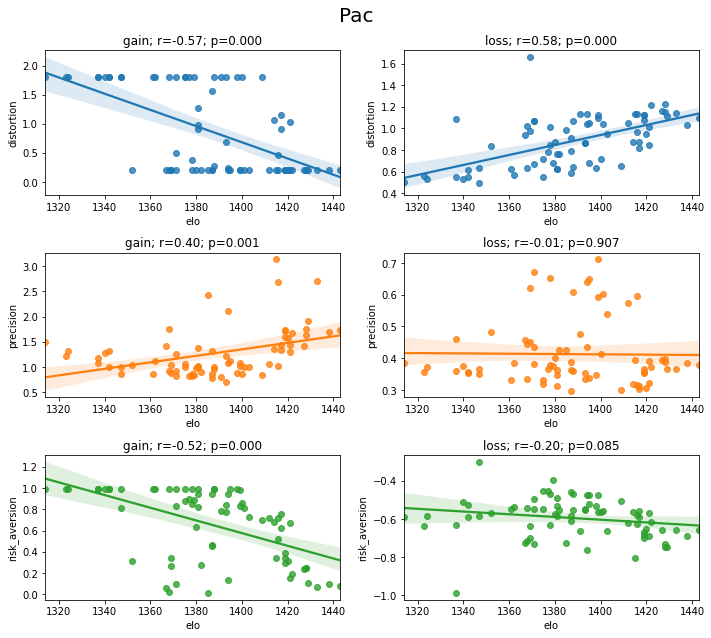

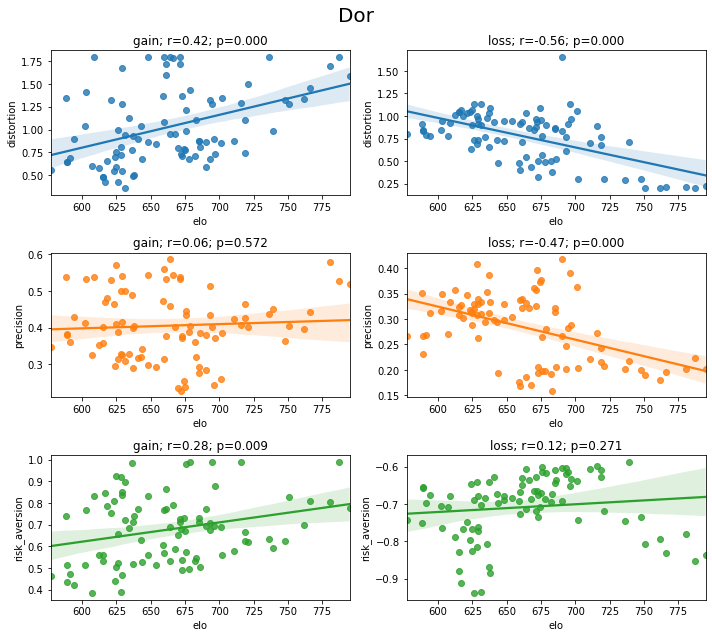

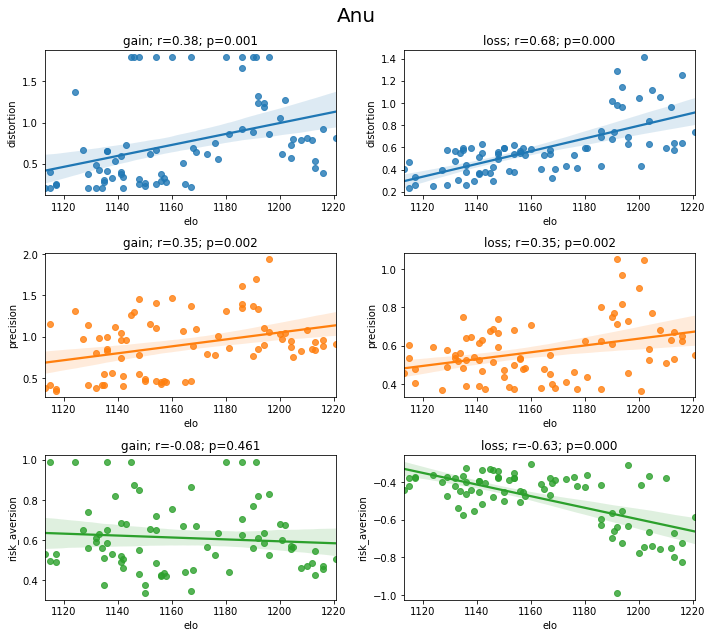

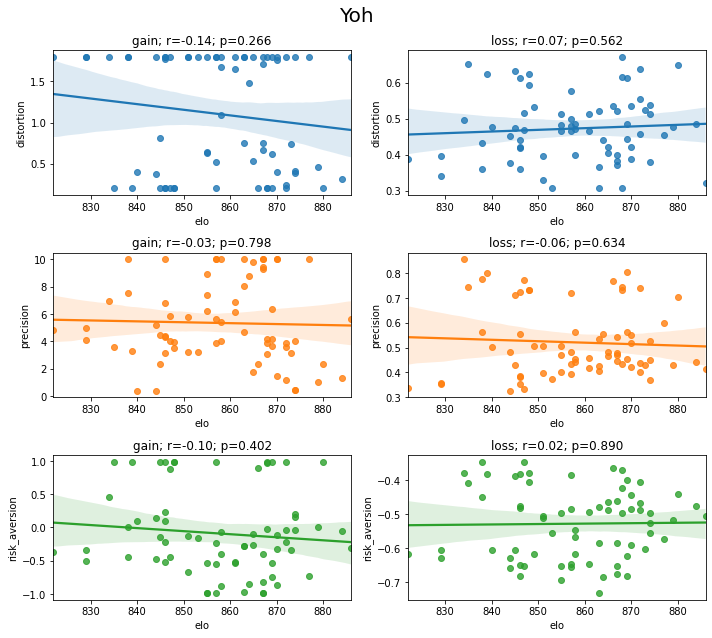

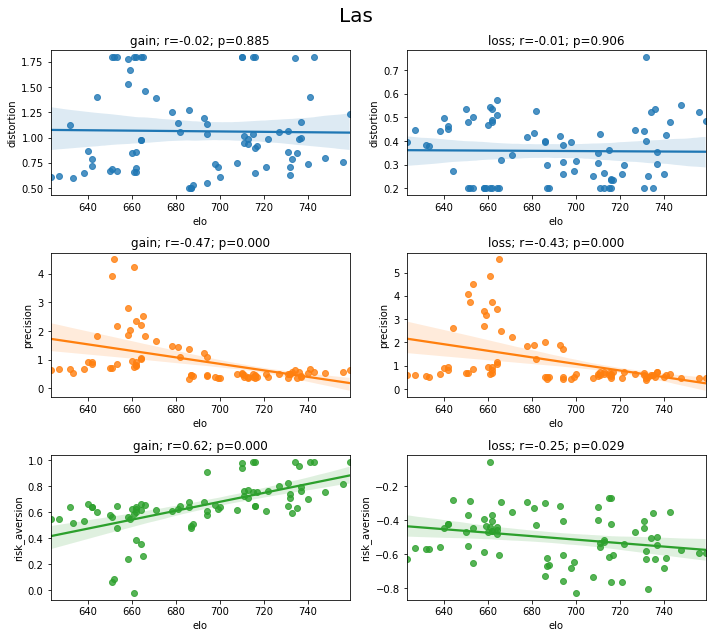

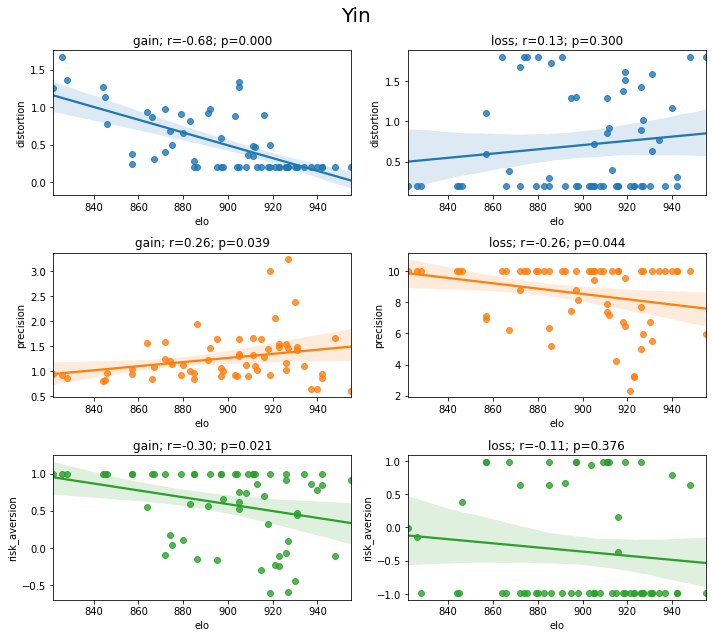

In [17]:
monkeys = df_fit.monkey.unique()
cond = ("gain", "loss")
n_param = len(Model.param_labels)

for i, m in enumerate(monkeys):
    
    fig, axes = plt.subplots(figsize=(10, 3*n_param), nrows=n_param, ncols=len(cond))
    fig.suptitle(m, fontsize=20)
    
    for j, cd in enumerate(cond):
        
        df_p = df_fit[(df_fit.monkey == m) & (df_fit.condition == cd)]
        
        df_elo_m = df_elo[m.lower()]
        df_elo_m = df_elo_m[df_elo_m.index >= min(df_p.date)]
        
        for k in range(n_param):
            
            param = Model.param_labels[k]
            
            df_ = pd.DataFrame({
                param: df_p[param].values, 
                "elo": df_elo_m        
            }, index=df_p.date)
            
            r_, p = scipy.stats.pearsonr(df_.elo, df_[param].values)
            
            ax = axes[k, j]
            t = f"{cd}; r={r_:.2f}; p={p:.3f}"
            ax.set_title(t)
            
            sns.regplot(x="elo", y=param, data=df_, color=f"C{k}", ax=ax)
    
    plt.tight_layout()
    plt.show()

In [20]:
monkeys = df_fit.monkey.unique()
cond = df_fit.condition.unique()
param = Model.param_labels    

d = [] 

for i, m in enumerate(monkeys):
    
    for j, cd in enumerate(cond):
        
        df_p = df_fit[(df_fit.monkey == m) & (df_fit.condition == cd)]
        
        df_elo_m = df_elo[m.lower()]
        df_elo_m = df_elo_m[df_elo_m.index >= min(df_p.date)]
        
        for k, pr in enumerate(param):
  
            df_ = pd.DataFrame({
                pr: df_p[pr].values, 
                "elo": df_elo_m        
            }, index=df_p.date)
            
            r_, p = scipy.stats.pearsonr(df_.elo, df_[pr].values)
            
            d.append({"monkey": m, "condition": cd, "param": pr, "r": r_, "p": p})

df = pd.DataFrame(d)
            
for cd in cond:
    for pr in param:
        d = df[(df.param == pr) & (df.condition == cd)]
        sgn = d.p < 0.05
        pos = d[sgn].r > 0
        neg = d[sgn].r < 0
        print(f"{pr}-{cd}: {np.sum(sgn)} sign. ({np.sum(pos)} +, {np.sum(neg)} -)")

distortion-gain: 5 sign.; (3 +, 2 -)
precision-gain: 9 sign.; (5 +, 4 -)
risk_aversion-gain: 7 sign.; (4 +, 3 -)
distortion-loss: 5 sign.; (2 +, 3 -)
precision-loss: 9 sign.; (3 +, 6 -)
risk_aversion-loss: 6 sign.; (2 +, 4 -)
